## 베이스라인 모델 : 단순 회귀
- 목적
    - 비교를 위한 베이스라인 모델 생성
    - 베이스라인 : 비교 대상이 될 모델
- 핵심
    - Target 값의 분포를 찍어보고 => 몰려있다면 Log
    - 베이스라인이기 때문에 성능이 낮다고 좌절 금지
- 다루는 내용
    - `Target` 분포 확인
    - Simple Linear Regression


In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='python-machine-deep-learning' # 여기에 여러분들의 프로젝트 ID를 넣어주세요

### 전처리

In [2]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)                                  -- 10. nyc_taxi의 모든것, gis에서 zip_code_geom제외 모든것 select
  FROM (
    SELECT *                                                                       -- 4. 전체 데이터를 select
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`          -- 1. 여기서 데이터 가져올것
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1                                    -- 2. 1월달인것만 고름
        and pickup_latitude  <= 90 and pickup_latitude >= -90                      -- 3. -90 <= pickup_latitude <= 90인것만 고름
    ) AS nyc_taxi                                                                  -- 5. 여기까지 뽑은 데이터를 nyc_taxi라고 이름지음
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom           -- 8. zip_code, state_code, state_name, city, country, zup_code_geop 선택
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`                        -- 6. 여기서 데이터 가져올것
    WHERE state_code='NY'                                                          -- 7. state_code='NY'인 것만 고름
    ) AS gis                                                                       -- 9. 8번에서 select한 데이터를 gis라고 이름지음
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))   -- 10. 두 데이터셋을 합침
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

Wall time: 21 s


In [3]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

In [4]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Linear Regerssion
- Baseline 모델
    - 작업한 모델 중 제일 성능이 낮을 모델, 비교 대상 

### Target 분포 확인

In [5]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10029,2015-01-01,1,1,3,0,0,204
1,11217,2015-01-01,1,1,3,0,0,121
2,10167,2015-01-01,1,1,3,0,0,18
3,10153,2015-01-01,1,1,3,0,0,30
4,10165,2015-01-01,1,1,3,0,0,39


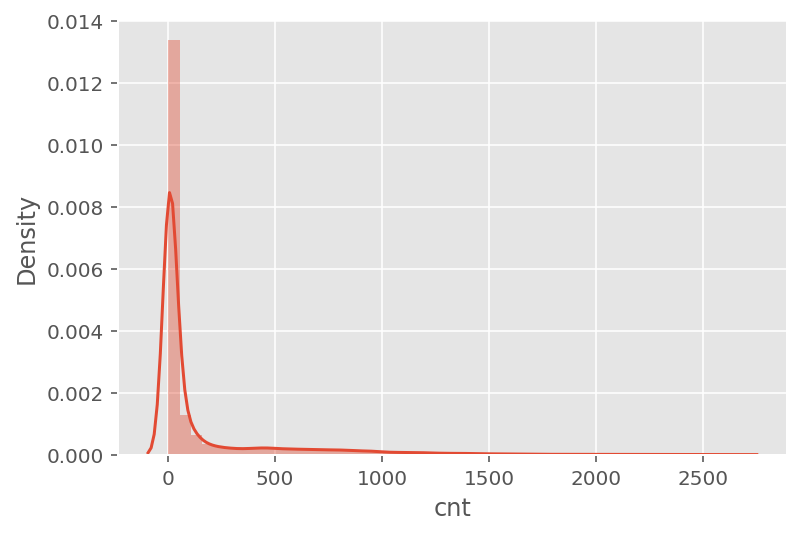

In [6]:
# 전체 분포
sns.distplot(base_df['cnt']);

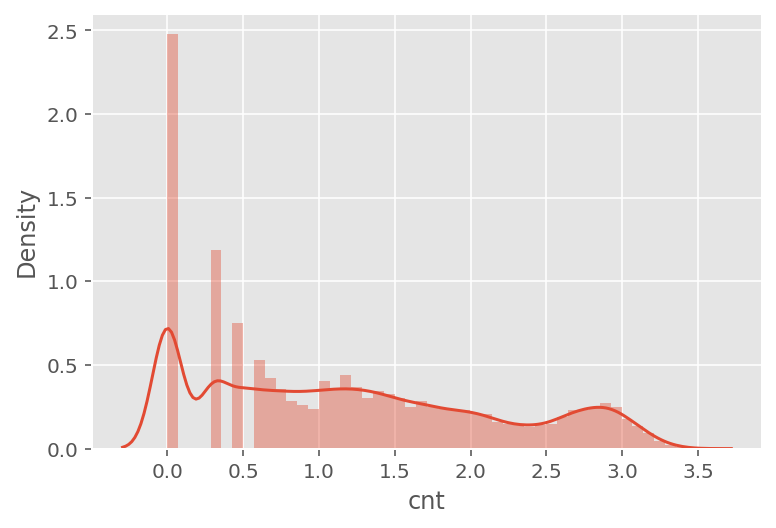

In [7]:
# 전체 분포 log화
sns.distplot(np.log10(base_df['cnt']));

### Widget으로 파악

In [8]:
def visualize_dist_by_zipcode(df, log=False):
    def view_images(zip_code):
        if log:
            data = np.log10(df.loc[df['zip_code'] == str(zip_code)]['cnt'])
        else:
            data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        ax = sns.distplot(data);
        ax.set_title(f'log is {log}, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [9]:
visualize_dist_by_zipcode(ohe_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

In [10]:
visualize_dist_by_zipcode(base_df, log=True)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

- 그냥 한번에 보도록 함수 수정

In [11]:
def visualize_dist_by_zipcode_at_the_same_time(df):
    def view_images(zip_code):
        fig, axs = plt.subplots(ncols=2, figsize=(15,5))

        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        ax1 = sns.distplot(raw_data, ax=axs[0]);
        ax2 = sns.distplot(log_data, ax=axs[1]);
        ax1.set_title(f'log is False, zip_code : {zip_code}')
        ax2.set_title(f'log is True, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [12]:
visualize_dist_by_zipcode_at_the_same_time(base_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

- log_cnt 생성

In [13]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

### Train / Test 나누기

In [14]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [15]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65113,11413,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000
65114,10004,2015-01-23 23:00:00,1,23,4,23,0,130,2.113943
65115,11373,2015-01-23 23:00:00,1,23,4,23,0,8,0.903090
65116,11421,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000
65117,10475,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000


In [16]:
test_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
87015,10020,2015-01-31 23:00:00,1,31,5,23,1,66,1.819544
87016,10044,2015-01-31 23:00:00,1,31,5,23,1,6,0.778151
87017,11103,2015-01-31 23:00:00,1,31,5,23,1,29,1.462398
87018,10451,2015-01-31 23:00:00,1,31,5,23,1,3,0.477121
87019,11373,2015-01-31 23:00:00,1,31,5,23,1,5,0.698970


- 사용하지 않을 컬럼 삭제

In [17]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [18]:
train_df.head(2)

,zip_code,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10029,1,1,3,0,0,204,2.309630
1,11217,1,1,3,0,0,121,2.082785


In [19]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [20]:
x_train = train_df.copy()
x_test = test_df.copy()

### Simple Regression
- One Hot Encoding 없이 그냥

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([0.34248883, 1.55472324, 1.4313428 , ..., 0.93741938, 1.49996517,
       0.70446331])

In [22]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [23]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [24]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


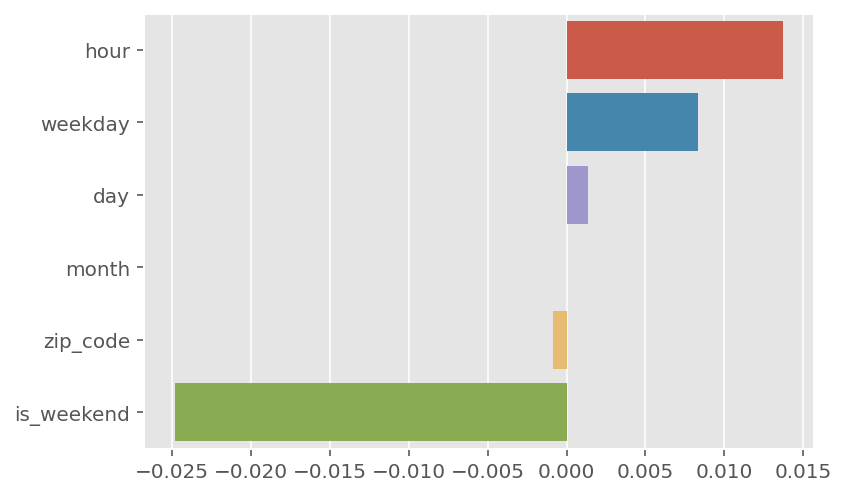

In [25]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

### One Hot Encoding

- One Hot Encoding을 사용해 Regression

In [26]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [27]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([-0.01112986,  2.47445154,  1.061728  , ...,  1.22119761,
        0.70156527,  0.89870119])

In [28]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [29]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.011130,0.974698,0.000000,1
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.474452,298.161484,2.929930,851
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.061728,11.527311,1.491362,31
65121,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.387993,24.433931,1.812913,65
65122,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.055134,11.353618,1.397940,25


In [30]:
test_df.head(3)

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.011130,0.974698,0.000000,1
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.474452,298.161484,2.929930,851
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.061728,11.527311,1.491362,31


In [31]:
# inf를 제외하기 위한 전처리
test_df = test_df[np.isfinite(test_df).all(1)]

In [32]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.64383,66.94515,27023.462798


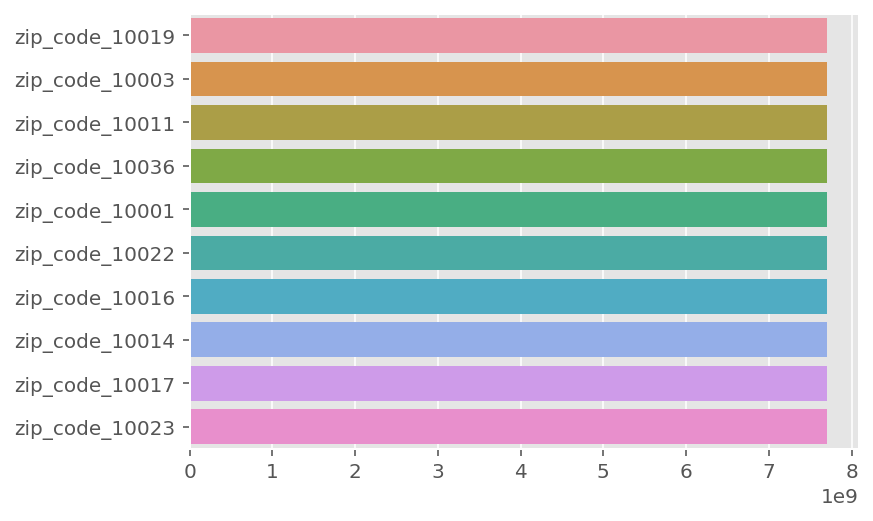

In [33]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);